
## 선형 모델 구성하기




In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_formaat ='retina'
%matplotlib inline

In [110]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [111]:
train.head()
test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


train데이터 뿐만아니라 test데이터에도 일괄적으로 전처리(정규화 및 인코딩)을 적용하기 위해 데이터를 합쳐준다.

In [139]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price+1)'}>]], dtype=object)

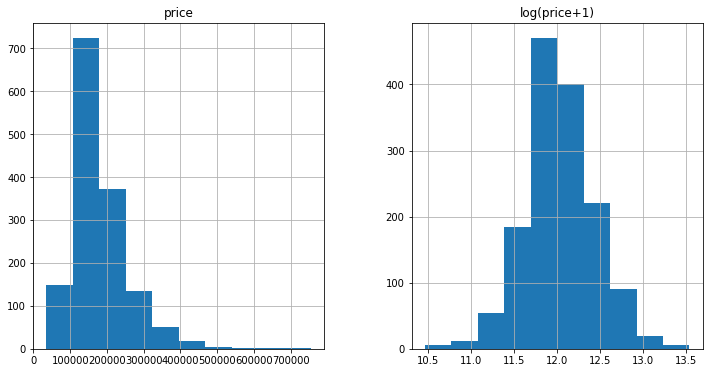

In [113]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

prices = pd.DataFrame({"price":train["SalePrice"], "log(price+1)":np.log1p(train["SalePrice"])})
prices.hist()

위에서 로그 변환을 통해 SalePrice를 정규화했다.
여기서는 수치형 변수들을 타겟팅해 왜도가 높은 변수들에 대한 정규화를 일괄적으로 수행한다.

* Series(or DF).apply 함수를 통해 각 컬럼에 대한 왜도를 매칭시킨다.
* 왜도가 0.75이상인 변수들의 인덱스를 구한다.
* 위에서 구한 인덱스들에 대해 log(p+1)변환을 적용해 정규화시킨다.
* 저자는 따로 설명하지 않았지만, 행에 음수값이 있다면 양수로 변환하는 과정이 필요할듯 하다.

In [114]:
train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = all_data.dtypes[all_data.dtypes !="object"].index

skewed_feats = train[numeric_feats].apply(lambda x:skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

MSSubClass       1.406210
LotFrontage      2.160866
LotArea         12.195142
OverallQual      0.216721
OverallCond      0.692355
YearBuilt       -0.612831
YearRemodAdd    -0.503044
MasVnrArea       2.666326
BsmtFinSF1       1.683771
BsmtFinSF2       4.250888
dtype: float64


In [115]:
all_data = pd.get_dummies(all_data)

In [116]:
all_data = all_data.fillna(all_data.mean())

In [117]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y= train.SalePrice

## Models

sklearn 모듈에서 정규화된 모듈을 사용해보자. l1,l2 모두 사용해보자.

In [118]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [141]:
model_ridge= Ridge()

In [120]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10 ,15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

Text(0, 0.5, 'rsme')

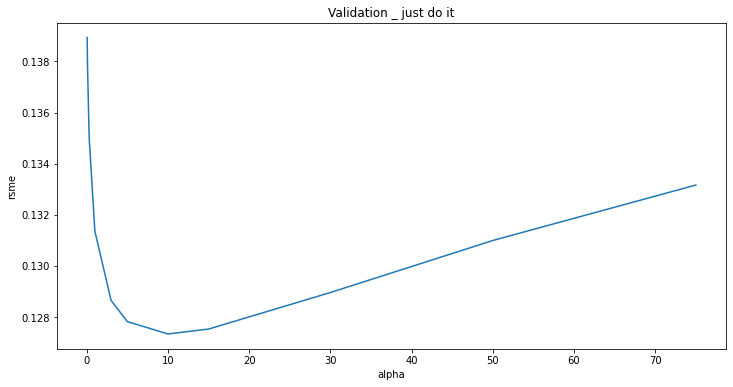

In [121]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title="Validation _ just do it")
plt.xlabel("alpha")
plt.ylabel("rsme")

정규화모델의 특징은 U자 형태로 나타나는데, 모델은 알파값이 너무 클 때 정규화가 너무 강하게 일어나 데이터의 복잡성을 따라가지 못한다. 반대로 알파값이 너무 작으면 데이터에 오버피팅된다.

In [122]:
cv_ridge.min()

0.12733734668670754

릿지 회귀에서 rmsle 0.127을 얻었다.

라쏘 모델도 테스트해보자. 구현된 LassoCV를 통해 위의 방법과 조금 다른 방법으로 최적 alpha값에 접근할것이다. 모종의 이유로 릿지회귀와는 정 반대의 순서로 알파를 구성한다. 

In [123]:
model_lasso = LassoCV(alphas=[1,0.1,0.001,0.0005]).fit(X_train,y)

In [124]:
rmse_cv(model_lasso).mean()

0.12256735885048131

라쏘 모델이 조금 더 나은 예측값을 가지므로, 테스트 케이스에도 그대로 사용할것이다. 라쏘의 좋은점은, 특징선택을 해준다는 점이다. 

In [125]:
coef = pd.Series(model_lasso.coef_, index= X_train.columns)

In [126]:
print("Lasso picked  " + str(sum(coef !=0)) +  "variables and eliminated the other "+str(sum(coef==0)) +" variables")

Lasso picked  110variables and eliminated the other 178 variables


여기서 고른 특징들이 반드시 옳은 특징들은 아니다. 특히 공선성을 갖는 경우가 있어, 부트스트랩 샘플들에 대한 라쏘 모델을 몇번 실행시키고 이 결과가 얼마나 안정적인지 직접 살펴야 한다

In [127]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

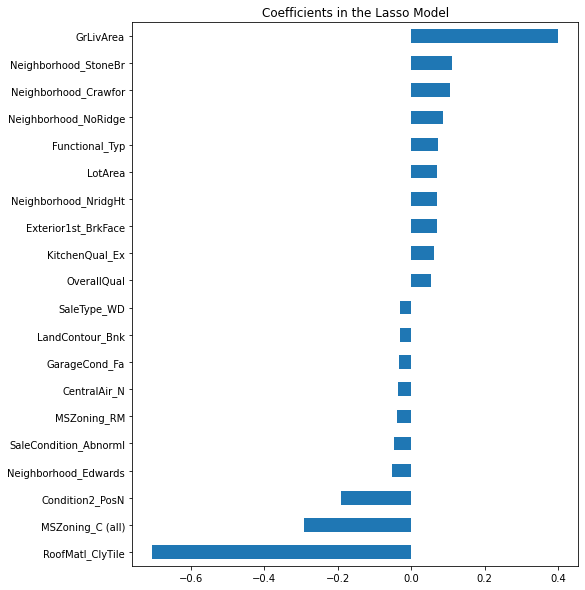

In [128]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")

양의 상관성을 갖는 가장 중요한 특징은 지상면적을 뜻하는 GrLivArea이다. 확실히 개연성이 있지만, 음의 상관성을 갖는 특징중 일부로는 불균형적인 범주형 변수에서 비롯된 것 일수도 있다.

Random forest에서 얻은 특징 중요도와는 달리 이는 실제 모델 계수이다. 따라서 예측된 가격이 왜 그렇게 되었는지 정확히 말할 수 있다. 따라서 로그변환된 타겟,숫자형 변수에 대한 실질적인 크기 예측이 조금 힘들다는 점이다.

<AxesSubplot:xlabel='preds', ylabel='residuals'>

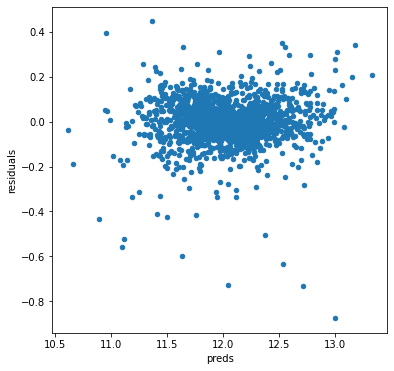

In [129]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y="residuals", kind="scatter")

## XGBoost 모델 추가하기

In [130]:
import xgboost as xgb

In [131]:

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot:>

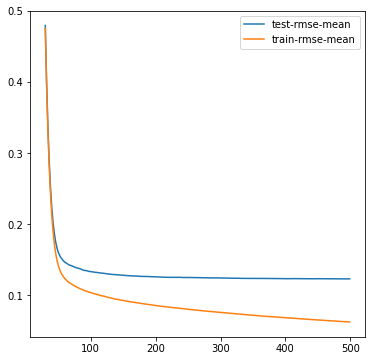

In [132]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [133]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

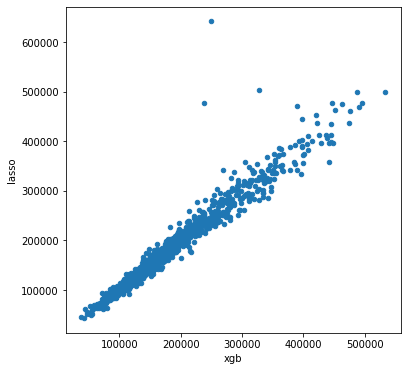

In [142]:
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [143]:
import math
math.sqrt(10)

3.1622776601683795